# Fetch and preprocess data

Fetch data from the database

In [1]:
from database_facade import db_facade

movies = db_facade.select_movies()
print(f'movies count: {len(movies)}')

movies count: 6461


Preprocess movie reviews helpers

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
import re
import emoji

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def convert_emoticons(text: str):
    emoticon_mapping = {
        ":)": "smile",
        ":-)": "smile",
        ":(": "sad",
        ":-(": "sad",
        ":D": "laugh",
        ":-D": "laugh"
    }
    
    words = text.split()
    converted_words = [emoticon_mapping.get(word, word) for word in words]
    converted_text = ' '.join(converted_words)
    
    return converted_text

def preprocess_text(text, return_tokens=False):

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)

    # Convert emoticons to text
    # text = convert_emoticons(text)

    # Replace emojis with names
    # text = emoji.demojize(text)

    # For now remove emojis completely - if the model works well might convert them to text as above
    text = emoji.replace_emoji(text, replace='')

    # Tokenization
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    # Text normalization
    tokens = [token.lower() for token in tokens]
    
    # Removing punctuation and elipsis
    tokens = [token for token in tokens if token not in string.punctuation and token != '...']
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return tokens if return_tokens else preprocessed_text

Split the data into training and test sets

In [5]:
train_test_split_ratio = 0.7

split_index = int(len(movies) * train_test_split_ratio)
train_movies = movies[:split_index]
test_movies = movies[split_index:]

print(f'Train movies count: {len(train_movies)}')
print(f'Test movies count: {len(test_movies)}')

Train movies count: 4522
Test movies count: 1939


# Dataset and DataLoaders

TMDBDataset class used to load movie data:
- movies should be split to training and test sets before passing them to the class (either pass training or test)
- each poster gets normalised,
- each image has it's height adjusted, so all posters have the same sizes before inputting them to the VAE.
- each movie sample gets all it's reviews preprocessed and a list of preprocessed content is returned

In [6]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from models.movie import Movie
import os
import cv2

class TMDBDataset(Dataset):
    def __init__(self, movies: List[Movie], directory, desired_image_shape, is_train):
        self.movies = movies
        self.directory = directory
        self.desired_image_shape = desired_image_shape
        self.is_train = is_train

    def __len__(self):
        # Calculate the number of batches per epoch
        return len(self.movies)

    def __getitem__(self, index: int):
        movie = self.movies[index]

        # ---- POSTERS ----
        file_path = movie.poster_path

        # Remove the '/' from the file path - the os lib uses '\' instead
        file_path = file_path[1:]

        # Load and preprocess the image
        image_path = os.path.join(self.directory, file_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Change image channels to RGB as cv2 reads BGR by default
        image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        resized_image = cv2.resize(image, (self.desired_image_shape[1], self.desired_image_shape[0])) # Resize the image to the desired width and height
        resized_image = resized_image.swapaxes(1, 2).swapaxes(0, 1)

        if self.is_train:
            return resized_image
        else:
            return resized_image, [preprocess_text(review.content) for review in movie.reviews]
        # return resized_image if self.is_train else resized_image, [preprocess_text(review.content) for review in movie.reviews]


# Posters

Draw a histogram of height distribution and find the minium and maximum pixel values

In [7]:
import matplotlib.pyplot as plt
from config import images_directory
import numpy as np

def draw_height_histogram():
    image_heights = []
    min_pixel_value = np.inf
    max_pixel_value = -np.inf

    for filename in os.listdir(images_directory):
        image_path = os.path.join(images_directory, filename)
        image = cv2.imread(image_path)

        height = image.shape[0]

        image_heights.append(height)

        current_min = np.min(image)
        current_max = np.max(image)
        
        if current_min < min_pixel_value:
            min_pixel_value = current_min
        if current_max > max_pixel_value:
            max_pixel_value = current_max

    num_unique_heights = len(set(image_heights))

    plt.hist(image_heights, bins=num_unique_heights)
    plt.xlabel('Image Height')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log') 
    plt.title('Distribution of Image Heights')
    plt.show()

    print(f'min pixel values:{min_pixel_value}')
    print(f'max pixel values:{max_pixel_value}')

Instantiate the variational autoencoder and the train TMDBDataset class used for the DataLoader

In [8]:
from variational_autoencoder_torch import VariationalAutoencoder

desired_image_shape = (256, 224)
batch_size = 16
train_TMDB_dataset = TMDBDataset(train_movies, images_directory, desired_image_shape, is_train=True)
train_TMDB_data_loader = DataLoader(train_TMDB_dataset, batch_size, shuffle=True)

vae = VariationalAutoencoder(input_height=desired_image_shape[0], input_width=desired_image_shape[1], latent_dim=64, device="cuda")

Train the VAE model using the ImageDataLoader class

In [97]:
epochs = 10
epoch_avg_train_losses = vae.train(data_loader=train_TMDB_data_loader, epochs=epochs)

Epoch 10/10: 100%|██████████| 283/283 [03:17<00:00,  1.43batch/s]


Save the trained model

In [9]:
import torch

In [98]:
torch.save(vae.state_dict(), 'trained_models/vae_posters_64dim_10epoch.pth')

Plot the average training loss per epoch

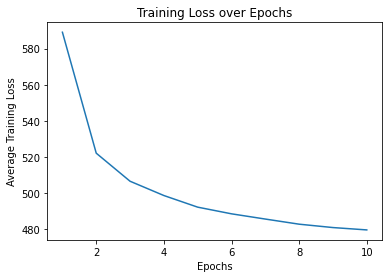

In [99]:
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, epoch_avg_train_losses)
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

Show reconstruction examples

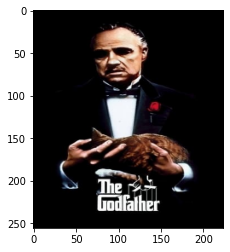

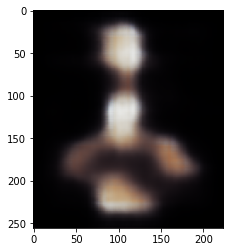

In [127]:
image = train_TMDB_dataset[127]
plt.imshow(image.swapaxes(0, 1).swapaxes(1, 2))

plt.show()

with torch.no_grad():
    reconstructed_image = vae(torch.Tensor(np.expand_dims(image, axis=0)).to("cuda"))
    plt.imshow(reconstructed_image[0][0].cpu().swapaxes(0, 1).swapaxes(1, 2))

# Reviews

 - The movie reviews are reduced using the pretrained bert model
 - for each movie from the dataset there can be more than 1 review
 - each review of a movie is reduced to a vector of 5 numbers representing scores from 1 to 5 (probability)
 - after calculating scores for all movie reviews an average vector is calculated, so each movie has one vector for its reviews
 - the review embeddings longer than 512 are truncated to fit the maximum input size for the network

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from config import hf_reviews_model
from scipy.special import softmax

reviews_tokenizer = AutoTokenizer.from_pretrained(hf_reviews_model)
reviews_model = AutoModelForSequenceClassification.from_pretrained(hf_reviews_model)

In [11]:
test_TMDB_dataset = TMDBDataset(test_movies, images_directory, desired_image_shape, is_train=False)

In [12]:
def calculate_average(list_of_lists):
    array = np.array(list_of_lists)
    averages = np.mean(array, axis=0)
    avg_list = averages.tolist()
    return [round(score, 5) for score in avg_list]

In [13]:
average_movie_review_scores = []

for _, reviews in test_TMDB_dataset:
    movie_review_scores = []

    review_embedding = reviews_tokenizer(reviews, return_tensors='pt', truncation=True, padding=True, max_length=512)
    batch_output = reviews_model(**review_embedding)
    batch_scores = batch_output[0].detach().numpy()
    for scores in batch_scores:
        movie_review_scores.append(softmax(scores))
    
    average_movie_review_scores.append(calculate_average(movie_review_scores))

print(len(average_movie_review_scores))

c:\Users\Xotra\AppData\Local\Programs\Python\Python39\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


1939


# Structural data

Create the pandas dataframe using the test data and remove columns that are redundant, separate genres as labels

In [14]:
import pandas as pd

test_df = pd.DataFrame([
    vars(movie) for movie in test_movies
])

columns_to_drop = [
    '_sa_instance_state', # sql alchemy state object not needed for clustering
    'id', # id is only needed for the ORM
    'poster_path', # VAE will handle posters - later the reduced poster vectors will be added to the df
    'original_title', # not needed - title feature will do
    'backdrop_path', # backdrops are not processed
    'reviews', # reviews are handled separately - scores vectors will be added later to the df
    'tagline', # about 60% of movies don't have taglines specified, so simply drop it
    'adult', # all movies from the endpoint are not adult movies, so drop it
    'video', # all movies so har had this flag set to 0 so drop it
    'status', # all movies that have been fetched have been released so drop it
    'spoken_languages' # original language property already determines the movie language, all the excessive languages are hard to process and an overkill
]

test_df = test_df.drop(columns=columns_to_drop)

#store the test_df before preprocessing so it's easy to compare later on
initial_df = test_df

labels = test_df['genres']
test_df = test_df.drop(columns=['genres'])

### Convert the movie titles and overviews to embeddings using the pretrained Sentence transformel model from HuggingFace

In [15]:
from sentence_transformers import SentenceTransformer

def get_sentence_embeddings(model: SentenceTransformer, sentences: List[str], embedding_name: str):
    embeddings = model.encode(sentences)
    embedding_column_dict = {f"{embedding_name}_embedding_{i}": [vector[i] for vector in embeddings] for i in range(384)}
    return pd.DataFrame(embedding_column_dict)

In [16]:
sentence_transformer_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

title_embeddings_df = get_sentence_embeddings(sentence_transformer_model, test_df['title'].tolist(), 'title')
overview_embeddings_df = get_sentence_embeddings(sentence_transformer_model, test_df['overview'].tolist(), 'overview')

Reduce embedding dimensionality using UMAP and cosine similarity

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

def reduce_embeddings_dim(embeddings_df, n_dim, n_neighbors, embedding_name):

    # Convert pandas df to numpy and perform min max scaling
    embeddings_array = np.array(embeddings_df)
    embeddings_scaled = MinMaxScaler().fit_transform(embeddings_array)

    # Reduce dimensionality using UMAP with cosine metric
    umap_embeddings = UMAP(n_neighbors=n_neighbors, n_components=n_dim, metric='cosine', random_state=420).fit_transform(embeddings_scaled)
    reduced_embeddings_column_dict = {f"{embedding_name}_embedding_{i}": [vector[i] for vector in umap_embeddings] for i in range(n_dim)}

    return pd.DataFrame(reduced_embeddings_column_dict)

In [18]:
title_embeddings_df = reduce_embeddings_dim(title_embeddings_df, 8, 15, 'title')
overview_embeddings_df = reduce_embeddings_dim(overview_embeddings_df, 12, 15, 'overview')

Substitute the title and overviews columns of test df with their respective embeddings

In [19]:
test_df = pd.concat([test_df, title_embeddings_df, overview_embeddings_df], axis=1).drop(columns=['title', 'overview'])

### Extract release year from the release date

In [20]:
test_df['release_year'] = test_df['release_date'].str.split('-', expand=True)[0].astype(int)
test_df = test_df.drop(columns=['release_date'])

### Perform binary encoding for the original language property

In [21]:
import category_encoders as ce

lang_binary_encoder = ce.BinaryEncoder(cols=['original_language'])
test_df = lang_binary_encoder.fit_transform(test_df)

### Reduce production countries

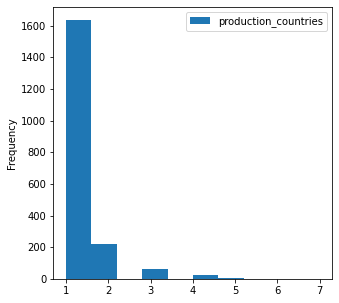

In [22]:
country_counts_df = test_df['production_countries'].apply(lambda countries: len(countries))
ax = country_counts_df.plot.hist(figsize=(5, 5), legend=True)

Majority of the movies have only one production country - for simplicity sake take only the first country object and map it to its abbreviation

In [23]:
test_df['prod_country_abv'] = test_df['production_countries'].apply(lambda countries: countries[0].iso_3166_1)
test_df = test_df.drop(columns=['production_countries'])

Perform binary encoding for the production country abbreviations

In [24]:
country_binary_encoder = ce.BinaryEncoder(cols=['prod_country_abv'])
test_df = country_binary_encoder.fit_transform(test_df)

### Reduce production companies

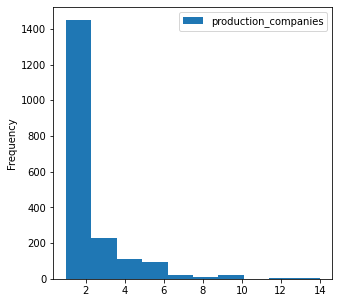

In [25]:
companies_counts_df = test_df['production_companies'].apply(lambda companies: len(companies))
ax2 = companies_counts_df.plot.hist(figsize=(5, 5), legend=True)

Same as for movie production countries - the majority of movies has only one production company, thus let's only take one and map it to its id, then binary encode

In [26]:
test_df['prod_company'] = test_df['production_companies'].apply(lambda companies: companies[0].id)
test_df = test_df.drop(columns=['production_companies'])

company_binary_encoder = ce.BinaryEncoder(cols=['prod_company'])
test_df = company_binary_encoder.fit_transform(test_df)

### Add the average review scores embeddings

In [27]:
avg_movie_scores_df = pd.DataFrame(average_movie_review_scores, columns=['1_star', '2_stars', '3_stars', '4_stars', '5_stars'])

test_df = pd.concat([test_df, avg_movie_scores_df], axis=1)

### Add the VAE poster embeddings

In [ ]:
# Load the trained model
poster_emb_dim = 64
vae = VariationalAutoencoder(input_height=desired_image_shape[0], input_width=desired_image_shape[1], latent_dim=poster_emb_dim, device="cuda")

vae.load_state_dict(torch.load(f'trained_models/vae_posters_{poster_emb_dim}dim_10epoch.pth'))

# Calculate the poster embeddings
poster_embeddings = []

for poster, _ in test_TMDB_dataset:
    with torch.no_grad():
        poster_embedding_tensor = vae.get_feature_vector(torch.Tensor(np.expand_dims(poster, axis=0)).to("cuda"))
        poster_embedding = poster_embedding_tensor[0].cpu().detach().numpy()

        poster_embeddings.append(poster_embedding)

# Convert embeddings to pandas df
poster_embedding_column_dict = {f"poster_embedding_{i}": [vector[i] for vector in poster_embeddings] for i in range(poster_emb_dim)}
poster_embeddings_df = pd.DataFrame(poster_embedding_column_dict)

# Add the poster embeddings to the test df
test_df = pd.concat([test_df, poster_embeddings_df], axis=1)

### Cast and directors embeddings

reduce arrays of People objects to strings formed by concatenating people names separated by white spaces

In [29]:
from models.person import Person

def reduce_people_list_to_string(people: List[Person]):
    return ' '.join(person.name for person in people)

test_df['cast'] = test_df['cast'].apply(reduce_people_list_to_string)
test_df['directors'] = test_df['directors'].apply(reduce_people_list_to_string)

In [30]:
cast_embeddings_df = get_sentence_embeddings(sentence_transformer_model, test_df['cast'].tolist(), 'cast')
directors_embeddings_df = get_sentence_embeddings(sentence_transformer_model, test_df['directors'].tolist(), 'directors')

In [31]:
cast_embeddings_df = reduce_embeddings_dim(cast_embeddings_df, 8, 12, 'cast')
directors_embeddings_df = reduce_embeddings_dim(directors_embeddings_df, 12, 10, 'directors')

In [32]:
test_df = pd.concat([test_df, cast_embeddings_df, directors_embeddings_df], axis=1).drop(columns=['cast', 'directors'])

# PCA + Clustering

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(test_df))

In [35]:
from sklearn.decomposition import PCA

def perform_pca(desired_variance_threshold=0.9):
    pca = PCA()
    pca.fit(X_scaled)

    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create the scree plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Scree Plot - Cumulative Explained Variance Ratio')
    plt.grid()
    plt.show()

    num_components_threshold = np.argmax(cumulative_variance >= desired_variance_threshold) + 1

    print(f"Number of dimensions to keep for {desired_variance_threshold:.2f} threshold: {num_components_threshold}")

    pca.n_components = num_components_threshold
    return pd.DataFrame(pca.transform(X_scaled))

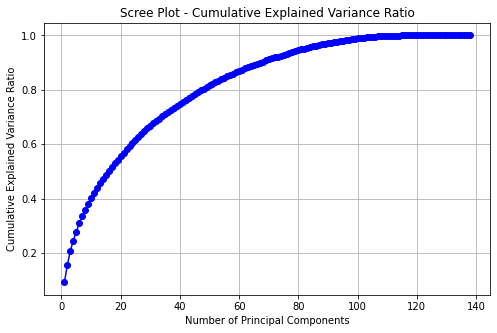

Number of dimensions to keep for 0.90 threshold: 68


In [36]:
X_scaled = perform_pca(0.9)

In [37]:
import hdbscan

def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='manhattan', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [46]:
from itertools import combinations
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

def avg_jaccard_similarity_score(true_labels, cluster_assignments, n_clusters):
    jaccard_similarity_scores = []

    for i in range(n_clusters):
        cluster_indices = np.where(cluster_assignments == i)[0]  # Get indices of data points in the cluster
        cluster_labels = [set(true_labels[idx]) for idx in cluster_indices]  # Get true labels for data points in the cluster
        
        # Calculate the Jaccard similarity between all pairs of labels within the cluster
        pairwise_jaccard_similarities = []
        for label1, label2 in combinations(cluster_labels, 2):
            intersection = len(label1.intersection(label2))
            union = len(label1.union(label2))
            jaccard_similarity = intersection / union if union > 0 else 0.0
            pairwise_jaccard_similarities.append(jaccard_similarity)

        # Average the pairwise Jaccard similarities for labels in this cluster
        average_jaccard_similarity = np.mean(pairwise_jaccard_similarities)
        jaccard_similarity_scores.append(average_jaccard_similarity)

    # Calculate the average Jaccard similarity across clusters as an overall evaluation metric
    return np.mean(jaccard_similarity_scores)

In [38]:
import random

from tqdm import trange

def random_search(embeddings, true_labels, space, num_evals):
    """
    Randomly search hyperparameter space and limited number of times 
    and return a summary of the results
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = space['random_state'])
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)

        avg_jaccard_score = avg_jaccard_similarity_score(true_labels ,clusters.labels_, label_count-1)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost, avg_jaccard_score])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost', 'avg_jaccard_score'])
    
    return result_df.sort_values(by=['avg_jaccard_score', 'cost'])

In [39]:
space = {
    "n_neighbors": range(8,18),
    "n_components": range(3,15),
    "min_cluster_size": range(6,12),
    "random_state": 42
}

# flatten list of Genre objects to the lists of their respective ids
get_id = lambda genre: genre.id

y_true = []

for genre_list in labels:
    y_true.append([get_id(genre) for genre in genre_list])

# random_search_results = random_search(X_scaled, y_true, space, 100)

In [ ]:
from collections import Counter
Output = Counter([tuple(i) for i in y_true])

most_common_genres_dict = {}
most_common_genres_counter = Output.most_common(15)

for i, counter_tuple in enumerate(most_common_genres_counter):
    genre_combination_tuple = tuple(sorted(counter_tuple[0]))
    most_common_genres_dict[genre_combination_tuple] = i

def reduce_genre_labels_to_most_common(labels, most_common_genres_dict, most_common_genres_counter):
    labels = tuple(sorted(tuple(labels)))
    if labels in most_common_genres_dict:
        return most_common_genres_dict[labels]
    
    labels = set(labels)

    highest_intersection_len = 0
    key_with_best_intersection = None

    for label_combo_counter in most_common_genres_counter:
        label_combo = set(label_combo_counter[0])

        intersection_len = len(labels.intersection(label_combo))

        if (intersection_len > highest_intersection_len):
            highest_intersection_len = intersection_len
            key_with_best_intersection = tuple(sorted(tuple(label_combo)))

    if key_with_best_intersection == None:
        print("ERROR - no intersection for specified label")
        print(labels)
        return None
        
    return most_common_genres_dict[key_with_best_intersection]

reduced_labels = []
for genre_id_list in y_true:
    reduced_label = reduce_genre_labels_to_most_common(genre_id_list, most_common_genres_dict, most_common_genres_counter)
    reduced_labels.append(reduced_label)

HDBSCAN

In [40]:
def search_best_HDBSCAN(data, param_grid, y_true):
    results = []

    for min_cluster_size in param_grid['min_cluster_size']:
        # for max_cluster_size in param_grid['max_cluster_size']:
        for cluster_selection_method in param_grid['cluster_selection_method']:
            for metric in param_grid['metric']:

                hdbscan_obj = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric=metric, cluster_selection_method=cluster_selection_method)
                hdbscan_labels = hdbscan_obj.fit_predict(data)

                n_clusters = len(np.unique(hdbscan_labels)) - 1

                if n_clusters == 1:
                    print(min_cluster_size, cluster_selection_method, metric)
                    break

                silhouette = round(silhouette_score(data, hdbscan_labels),3)
                davies_bouldin = round(davies_bouldin_score(data, hdbscan_labels),3)
                calinski_harabasz = round(calinski_harabasz_score(data, hdbscan_labels),3)
                avg_jaccard =round(avg_jaccard_similarity_score(y_true, hdbscan_labels, n_clusters),3)

                results.append([min_cluster_size, cluster_selection_method, metric, n_clusters, silhouette, davies_bouldin, calinski_harabasz, avg_jaccard])
    
    result_df = pd.DataFrame(results, columns=['min_cluster_size', 'cluster_selection_method','metric','n_clusters', 'SS', 'DB', 'CH', 'JC'])
    
    return result_df.sort_values(by=['SS', 'JC', 'DB','CH'], ascending=[False, False, True, False])

In [42]:
hdbscan_param_grid = {
    'min_cluster_size': [8, 10, 15, 20],
    # 'max_cluster_size': [50, 100, 200, 300],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

hdbscan_reduced_data = reduce_embeddings_dim(X_scaled, 8, 12, 'hdbscan')

hdbscan_results = search_best_HDBSCAN(hdbscan_reduced_data, hdbscan_param_grid, y_true)

In [ ]:
hdbscan_results.head(10)

In [49]:
clusters = hdbscan.HDBSCAN(min_cluster_size = 8,
                               metric='chebyshev', 
                               cluster_selection_method='eom').fit(hdbscan_reduced_data)

res = pd.DataFrame(clusters.labels_, columns=['cluster_assignment'])

print(np.unique(clusters.labels_))

results = pd.concat([initial_df, res], axis=1)

[0 1 2 3 4 5 6]


In [124]:
results[results['cluster_assignment']==2]

,release_date,budget,title,popularity,revenue,vote_average,original_language,vote_count,overview,runtime,genres,production_companies,production_countries,cast,directors,cluster_assignment
304,2008-11-09,0,The Daisy Chain,5.937,0,5.351,en,57,A grieving couple move to a remote Irish villa...,89,"[<Genre id=18, name=Drama>, <Genre id=27, name...","[<Company id=25487, name=ContentFilm Internati...","[<Country iso_3166_1=GB, name=United Kingdom>,...","[<Person id=978, name=Steven Mackintosh>, <Per...","[<Person id=133873, name=Aisling Walsh>]",2
327,1955-09-22,3115000,The Tall Men,9.033,5000000,6.277,en,56,Two brothers discharged from the Confederate A...,122,"[<Genre id=12, name=Adventure>, <Genre id=37, ...","[<Company id=25, name=20th Century Fox, origin...","[<Country iso_3166_1=US, name=United States of...","[<Person id=4077, name=Harry Shannon>, <Person...","[<Person id=8823, name=Raoul Walsh>]",2
340,1956-05-22,0,Wicked as They Come,1.350,0,5.455,en,11,A ruthless woman takes advantage of gullible m...,94,"[<Genre id=18, name=Drama>]","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=GB, name=United Kingdom>]","[<Person id=2435, name=Herbert Marshall>, <Per...","[<Person id=70308, name=Ken Hughes>]",2
624,1940-04-15,0,Dark Command,5.248,0,6.400,en,37,When transplanted Texan Bob Seton arrives in L...,94,"[<Genre id=18, name=Drama>, <Genre id=37, name...","[<Company id=1432, name=Republic Pictures, ori...","[<Country iso_3166_1=US, name=United States of...","[<Person id=3341, name=Joe Sawyer>, <Person id...","[<Person id=8823, name=Raoul Walsh>]",2
818,1930-11-01,2000000,The Big Trail,8.867,0,6.697,en,94,Young scout Breck Coleman leads a wagon train ...,122,"[<Genre id=12, name=Adventure>, <Genre id=18, ...","[<Company id=5488, name=Fox Film Corporation, ...","[<Country iso_3166_1=US, name=United States of...","[<Person id=4165, name=John Wayne>, <Person id...","[<Person id=8823, name=Raoul Walsh>]",2
925,1953-10-09,0,Gun Fury,5.554,0,5.800,en,32,"After a stagecoach holdup, Frank Slayton's not...",83,"[<Genre id=12, name=Adventure>, <Genre id=28, ...","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=US, name=United States of...","[<Person id=9112, name=Neville Brand>, <Person...","[<Person id=8823, name=Raoul Walsh>]",2
961,1945-02-17,0,"Objective, Burma!",6.896,0,6.933,en,75,A group of men parachute into Japanese-occupie...,142,"[<Genre id=18, name=Drama>, <Genre id=28, name...","[<Company id=174, name=Warner Bros. Pictures, ...","[<Country iso_3166_1=US, name=United States of...","[<Person id=8724, name=Errol Flynn>, <Person i...","[<Person id=8823, name=Raoul Walsh>]",2
970,1942-11-14,0,Gentleman Jim,5.734,0,7.300,en,49,"As bare-knuckled boxing enters the modern era,...",104,"[<Genre id=18, name=Drama>, <Genre id=35, name...","[<Company id=174, name=Warner Bros. Pictures, ...","[<Country iso_3166_1=US, name=United States of...","[<Person id=2672, name=Jack Carson>, <Person i...","[<Person id=8823, name=Raoul Walsh>]",2
977,1951-06-02,0,Along the Great Divide,1.974,0,7.300,en,29,New Federal marshal Len Merrick saves Tim Keit...,88,"[<Genre id=12, name=Adventure>, <Genre id=37, ...","[<Company id=174, name=Warner Bros. Pictures, ...","[<Country iso_3166_1=US, name=United States of...","[<Person id=2090, name=Kirk Douglas>, <Person ...","[<Person id=8823, name=Raoul Walsh>]",2
1108,1957-08-27,0,The Long Haul,3.597,0,6.100,en,18,An American ex-GI takes a job as a truck drive...,88,"[<Genre id=18, name=Drama>, <Genre id=53, name...","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=GB, name=United Kingdom>]","[<Person id=10596, name=Norman Rossington>, <P...","[<Person id=70308, name=Ken Hughes>]",2


DBSCAN

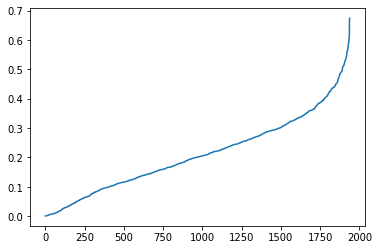

In [44]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

dbscan_reduced_data = reduce_embeddings_dim(X_scaled, 8, 12, 'dbscan')

# If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998)
min_pts = 2*10

neighbors = NearestNeighbors(n_neighbors=min_pts-1)
neighbors_fit = neighbors.fit(dbscan_reduced_data)
distances, indices = neighbors_fit.kneighbors(dbscan_reduced_data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

epsilon = 0.45

In [45]:
dbscan_labels = DBSCAN(eps=epsilon, min_samples=min_pts, metric='euclidean').fit_predict(dbscan_reduced_data)
print(np.unique(dbscan_labels))

[-1  0  1  2  3  4  5  6  7  8  9 10]


In [46]:
print(round(avg_jaccard_similarity_score(y_true, dbscan_labels, 8),3))
print(round(davies_bouldin_score(dbscan_reduced_data, dbscan_labels),3))
print(round(calinski_harabasz_score(dbscan_reduced_data, dbscan_labels),3))
print(round(silhouette_score(dbscan_reduced_data, dbscan_labels),3))

0.308
1.124
181.163
-0.227


In [47]:
dbscan_res = pd.DataFrame(dbscan_labels, columns=['cluster_assignment'])
dbscan_results = pd.concat([initial_df, dbscan_res], axis=1)

In [48]:
dbscan_results[dbscan_results['cluster_assignment']==10]

,release_date,budget,title,popularity,revenue,vote_average,original_language,vote_count,overview,runtime,genres,production_companies,production_countries,cast,directors,cluster_assignment
11,1975-09-26,4000000,Bite the Bullet,9.580,0,6.372,en,98,"At the beginning of the 20th century, a newspa...",132,"[<Genre id=12, name=Adventure>, <Genre id=28, ...","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=US, name=United States of...","[<Person id=193, name=Gene Hackman>, <Person i...","[<Person id=3632, name=Richard Brooks>]",10
324,1969-03-26,0,100 Rifles,13.133,0,5.800,en,78,When half-breed Indian Yaqui Joe robs an Arizo...,110,"[<Genre id=12, name=Adventure>, <Genre id=28, ...","[<Company id=25, name=20th Century Fox, origin...","[<Country iso_3166_1=US, name=United States of...","[<Person id=4774, name=Jim Brown>, <Person id=...","[<Person id=18592, name=Tom Gries>]",10
465,1950-03-01,0,The Kid from Texas,2.276,0,5.147,en,17,Billy the Kid becomes embroiled in Lincoln Cou...,78,"[<Genre id=37, name=Western>]","[<Company id=10330, name=Universal Internation...","[<Country iso_3166_1=US, name=United States of...","[<Person id=2755, name=Albert Dekker>, <Person...","[<Person id=70565, name=Kurt Neumann>]",10
468,1967-05-01,0,40 Guns to Apache Pass,4.227,0,4.800,en,16,The Apaches are on the warpath and the Army mu...,95,"[<Genre id=37, name=Western>]","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=US, name=United States of...","[<Person id=45114, name=Michael Blodgett>, <Pe...","[<Person id=32175, name=William Witney>]",10
469,1952-05-09,0,The Battle at Apache Pass,3.444,0,6.000,en,13,Major Jim Colton is a sympathetic leader who h...,85,"[<Genre id=37, name=Western>]","[<Company id=10330, name=Universal Internation...","[<Country iso_3166_1=US, name=United States of...","[<Person id=4965, name=Jack Elam>, <Person id=...","[<Person id=94096, name=George Sherman>]",10
486,1953-08-07,0,The Man from the Alamo,6.055,0,6.643,en,28,"During the war for Texas independence, one man...",79,"[<Genre id=37, name=Western>]","[<Company id=10330, name=Universal Internation...","[<Country iso_3166_1=US, name=United States of...","[<Person id=3381, name=Glenn Ford>, <Person id...","[<Person id=18574, name=Budd Boetticher>]",10
596,1983-06-10,0,Siege,1.211,0,6.300,en,24,During a police strike in Nova Scotia's capita...,84,"[<Genre id=28, name=Action>, <Genre id=53, nam...","[<Company id=26139, name=Salter Street Films, ...","[<Country iso_3166_1=CA, name=Canada>]","[<Person id=50775, name=Doug Lennox>, <Person ...","[<Person id=144430, name=Paul Donovan>, <Perso...",10
777,1958-05-07,0,The Left Handed Gun,9.603,0,6.006,en,89,"When a crooked sheriff murders his employer, W...",102,"[<Genre id=18, name=Drama>, <Genre id=28, name...","[<Company id=174, name=Warner Bros. Pictures, ...","[<Country iso_3166_1=US, name=United States of...","[<Person id=2784, name=Robert Foulk>, <Person ...","[<Person id=6448, name=Arthur Penn>]",10
835,1966-06-02,75000,The Shooting,8.312,0,6.438,en,96,"Two miners agree to guide a mysterious woman, ...",78,"[<Genre id=37, name=Western>]","[<Company id=34281, name=Santa Clara Productio...","[<Country iso_3166_1=US, name=United States of...","[<Person id=514, name=Jack Nicholson>, <Person...","[<Person id=20921, name=Monte Hellman>]",10
905,1957-04-02,0,The Tall T,11.031,0,6.900,en,113,"A pair of newlyweds, a ranch foreman, and thei...",78,"[<Genre id=37, name=Western>]","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=US, name=United States of...","[<Person id=1009, name=Randolph Scott>, <Perso...","[<Person id=18574, name=Budd Boetticher>]",10


Kmeans

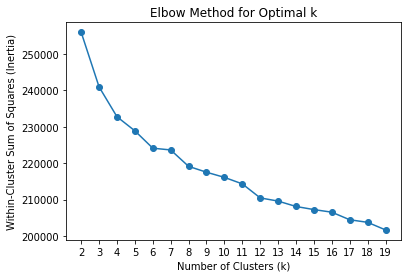

,k,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score,Average Jaccard Score
0,2,0.140,3.237,87.681,0.159
1,3,0.058,3.377,106.883,0.160
2,4,0.046,3.215,96.463,0.157
3,5,0.032,3.704,81.719,0.157
4,6,0.038,3.510,74.957,0.165
5,7,0.030,3.867,63.264,0.172
6,8,0.029,3.624,60.991,0.175
7,9,0.027,3.714,55.525,0.177
8,10,0.026,3.734,51.056,0.176
9,11,0.025,3.827,47.918,0.176


In [114]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

k_values = range(2, 20)
inertias = []
kmeans_silhouette_scores = []
kmeans_db_scores = []
kmeans_calinski_harabasz_scores = []
avg_jaccard_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    kmeans_silhouette_scores.append(silhouette_score(X_scaled, labels))
    kmeans_db_scores.append(davies_bouldin_score(X_scaled, labels))
    kmeans_calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    avg_jaccard_scores.append(avg_jaccard_similarity_score(y_true, labels, k))

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.show()

kmeans_scores = pd.DataFrame({
    'k': k_values,
    'Silhouette Score': kmeans_silhouette_scores,
    'Davies-Bouldin Index': kmeans_db_scores,
    'Calinski-Harabasz Score': kmeans_calinski_harabasz_scores,
    'Average Jaccard Score': avg_jaccard_scores
})
kmeans_scores = kmeans_scores.round(3)
kmeans_scores.head(20)

In [49]:
from sklearn.cluster import AgglomerativeClustering

def search_best_agglomerative(data, param_grid, y_true):
    results = []

    for n_clusters in param_grid['n_clusters']:
        for linkage in param_grid['linkage']:
            for metric in param_grid['metric']:
                if linkage == 'ward' and metric != 'euclidean':
                    continue

                hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)
                hierarchical_labels = hierarchical.fit_predict(data)

                silhouette = round(silhouette_score(data, hierarchical_labels, metric=metric),3)
                davies_bouldin = round(davies_bouldin_score(data, hierarchical_labels),3) if metric == 'euclidean' else None
                calinski_harabasz = round(calinski_harabasz_score(data, hierarchical_labels),3) if metric == 'euclidean' else None
                avg_jaccard = round(avg_jaccard_similarity_score(y_true, hierarchical_labels, n_clusters),3)

                results.append([n_clusters, linkage, metric, silhouette, davies_bouldin, calinski_harabasz, avg_jaccard])
    
    result_df = pd.DataFrame(results, columns=['n_clusters', 'linkage', 'metric','SS', 'DB', 'CH', 'JC'])
    
    return result_df.sort_values(by=['SS', 'DB', 'JC','CH'], ascending=[False, True, False, False])         

In [ ]:
param_grid = {
    'n_clusters': [10, 12, 14, 16, 18],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

agg_search_results = search_best_agglomerative(dbscan_reduced_data, param_grid, y_true)

In [ ]:
agg_search_results.head(10)

In [75]:
hierarchical = AgglomerativeClustering(n_clusters=10, linkage='single', metric='euclidean')
hierarchical_labels = hierarchical.fit_predict(dbscan_reduced_data)

agg_res = pd.DataFrame(hierarchical_labels, columns=['cluster_assignment'])
agg_results = pd.concat([initial_df, agg_res], axis=1)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linkage_matrix = linkage(dbscan_reduced_data, method='single', metric='euclidean')
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, p=30, truncate_mode='level', no_labels=True)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

In [78]:
agg_results[agg_results['cluster_assignment']==2]

,release_date,budget,title,popularity,revenue,vote_average,original_language,vote_count,overview,runtime,genres,production_companies,production_countries,cast,directors,cluster_assignment
74,1995-01-21,7500000,Rumble in the Bronx,32.065,32392047,6.791,cn,876,Keong comes from Hong Kong to visit New York f...,104,"[<Genre id=28, name=Action>, <Genre id=35, nam...","[<Company id=2521, name=Orange Sky Golden Harv...","[<Country iso_3166_1=HK, name=Hong Kong>]","[<Person id=10875, name=Françoise Yip>, <Perso...","[<Person id=44916, name=Stanley Tong>]",2
90,2006-06-28,0,Arang,5.733,0,5.900,ko,34,A salt storehouse near the sea may be haunted....,97,"[<Genre id=27, name=Horror>]","[<Company id=7819, name=Lotte Entertainment, o...","[<Country iso_3166_1=KR, name=South Korea>]","[<Person id=90472, name=Song Yun-ah>, <Person ...","[<Person id=111411, name=Ahn Sang-hoon>]",2
455,2010-06-10,40000000,The Karate Kid,60.223,359126022,6.529,en,5486,Twelve-year-old Dre Parker could have been the...,140,"[<Genre id=12, name=Adventure>, <Genre id=18, ...","[<Company id=5, name=Columbia Pictures, origin...","[<Country iso_3166_1=CN, name=China>, <Country...","[<Person id=18897, name=Jackie Chan>, <Person ...","[<Person id=21981, name=Harald Zwart>]",2
549,1993-05-13,0,The Untold Story,15.929,0,6.000,cn,105,"In 1978 in Hong Kong, a grisly murder takes pl...",95,"[<Genre id=18, name=Drama>, <Genre id=27, name...","[<Company id=44692, name=Uniden Investments Li...","[<Country iso_3166_1=HK, name=Hong Kong>]","[<Person id=26784, name=Danny Lee Sau-Yin>, <P...","[<Person id=92831, name=Herman Yau>]",2
562,1993-11-04,0,Green Snake,14.002,0,7.100,cn,79,A mischievous snake who assumes human form int...,99,"[<Genre id=14, name=Fantasy>, <Genre id=28, na...","[<Company id=3618, name=Film Workshop, origin_...","[<Country iso_3166_1=HK, name=Hong Kong>]","[<Person id=1338, name=Maggie Cheung>, <Person...","[<Person id=26760, name=Tsui Hark>]",2
597,2009-12-23,12000000,Woochi: The Demon Slayer,16.904,0,6.626,ko,111,"Spanning four centuries in Korea, this epic ac...",136,"[<Genre id=12, name=Adventure>, <Genre id=14, ...","[<Company id=7036, name=CJ Entertainment, orig...","[<Country iso_3166_1=KR, name=South Korea>]","[<Person id=37939, name=Yum Jung-ah>, <Person ...","[<Person id=119337, name=Choi Dong-hoon>]",2
687,2000-01-01,0,Peppermint Candy,12.879,0,7.527,ko,207,7 episodes in the life of a middle-aged South ...,131,"[<Genre id=18, name=Drama>]","[<Company id=6596, name=UniKorea Pictures, ori...","[<Country iso_3166_1=KR, name=South Korea>]","[<Person id=16264, name=Lee Eol>, <Person id=3...","[<Person id=96657, name=Lee Chang-dong>]",2
834,1967-08-13,0,"Yongary, Monster from the Deep",5.434,0,4.500,ko,69,Earthquakes in central Korea turn out to be th...,79,"[<Genre id=27, name=Horror>, <Genre id=878, na...","[<Company id=5542, name=Toei Animation, origin...","[<Country iso_3166_1=JP, name=Japan>, <Country...","[<Person id=566367, name=Lee Soon-jae>, <Perso...","[<Person id=1286104, name=Kim Kee-duk>]",2
1139,2002-02-06,0,Chinese Odyssey 2002,5.041,0,6.780,cn,41,Two pairs of siblings are destined for each ot...,97,"[<Genre id=28, name=Action>, <Genre id=35, nam...","[<Company id=539, name=Block 2 Pictures, origi...","[<Country iso_3166_1=HK, name=Hong Kong>]","[<Person id=1337, name=Tony Leung Chiu-wai>, <...","[<Person id=57617, name=Jeffrey Lau>]",2
1141,1994-01-29,0,Treasure Hunt,5.214,0,5.923,cn,13,A C.I.A. agent is assigned to go to Beijing to...,111,"[<Genre id=14, name=Fantasy>, <Genre id=28, na...","[<Company id=6213, name=Golden Princess Film P...","[<Country iso_3166_1=HK, name=Hong Kong>]","[<Person id=695, name=Roy Chiao>, <Person id=1...","[<Person id=57617, name=Jeffrey Lau>]",2
